# Imports

In [1]:
import pandas as pd
import numpy as np
import playlists
import implicit
import pickle
import matplotlib.pyplot as plt
import spotipy
from spotipy.oauth2 import SpotifyOAuth
from scipy.sparse import csr_matrix
from scipy.sparse import vstack
from implicit import evaluation

# Gathering Songs Data

### Loads Data If Data Already Gathered

In [12]:
# Uses saved pickle to get songs_list, songs_index, and user_playlist matrix
pl_lst_flat, songs_list, songs_index, data = pickle.load(open('songs_playlist_matrix_data.p', 'rb'))

### Creates Songs List/Song index Dict (Must Run for Testing Purposes)

In [7]:
# Creates an empty series to concatenate to later
songs_list = pd.Series(dtype = str)

# Passes in the first playlist from playlists jsons
pl_lst = [playlists.read_playlists('../data/playlist_data/data/mpd.slice.0-999.json')]

# Passes in the other 14000 playlists
for i in range (1,15):
    pl_lst.append(playlists.read_playlists(f'../data/playlist_data/data/mpd.slice.{i}000-{i}999.json'))

# Flattens the list to create 15,000 entry of playlistss
pl_lst_flat = [element for sublist in pl_lst for element in sublist]

# For loop that takes in all of the songs and artists from the playlists, then puts them in a songs list
for i in range(1000):
    for j in pl_lst:
        concat_list = pd.Series(j[i][1]['track_name'] + ', ' + j[i][1]['artist_name'])
        songs_list = pd.concat([concat_list,songs_list]).drop_duplicates().reset_index(drop=True)

# Dictionary to store the indeces of songs (used for testing purposes mainly)
songs_index = {songs_list[i]: i for i in range(len(songs_list))}

### Fills In Sparse Matrix of User, Playlist info

In [ ]:
# Fills in the first playlist in a sprase matrix csr of shape (1, len(songs_list) {215278}) (needed for vstack)

# Creates a series of tracks from the first playlist
tracks = (pl_lst[0][0][1]['track_name'] + ', ' + pl_lst[0][0][1]['artist_name']).drop_duplicates()

# Creates an array of ones and zeros the same length as the tracks series
ones = np.ones(len(tracks), dtype = np.int8)
zeros = np.zeros(len(tracks), dtype = np.int8)

# Creates an array of song indices using the tracks series
song_indices = [songs_index[i] for i in tracks]

# Creates a 1 row csr_matrix with 1 in every column of song indeces
data = csr_matrix((ones, (zeros, song_indices)), shape=(1, len(songs_list)))

# Loops through all playlists to fill in the user song table
loopnum = 0
for i in pl_lst:
    # Skips the first row of the matrix since it's already created
    if(loopnum == 0):
        start = 1
    else: start = 0
        
    # For loop that fills in the entire user playlist matrix
    for j in range(start, 1000):
        
        # Creates a series of tracks from j playlist
        tracks = i[j][1]['track_name'] + ', ' + i[j][1]['artist_name']
        
        # Creates an array of ones and zeros the same length as the tracks series
        ones = np.ones(len(tracks), dtype = np.int8)
        zeros = np.zeros(len(tracks), dtype = np.int8)
        
        # Creates an array of song indices using the tracks series
        song_indices = [songs_index[k] for k in tracks]
        
        # Creates a 1 row csr_matrix with 1 in every column of song indeces
        new_user = csr_matrix((ones, (zeros, song_indices)), shape=(1, len(songs_list)))
        
        # Stacks the row of matrix for the new user to user playlist matrix
        data = vstack([data, new_user])
        
    # Sets loopnum to 1 so it doesn't skip any other playlists
    loopnum = 1

# Checks if the matrix was properly filled in
print(data)

# Creates Testing (Hit Rate and NDCG) and Plotting Functions

In [14]:
# Called by the model when training to output progress
def test_acc(epoch, time, correct, skipped, model):

    # Creates empty lists
    ndcg = []
    ndcg_train_lst = []
    hits = []
    hits_train = []
    
    # Uses leave one k out testing on the train data
    train_usr, test_usr = evaluation.leave_k_out_split(train)
    
    # Gives a list of users that are both in the test and train data set after second split 
    # (sometimes there are users not in test)
    commons = list(set(train_usr.nonzero()[0]).intersection(test_usr.nonzero()[0]))
    
    # For loop that goes through all user playlists
    for i in commons:
        
        # Creates a random list of 100 songs then appends a song from the original training data set before the split
        random_songs = np.random.randint(len(songs_list), size = 100)
        random_songs = np.append(random_songs, (test_usr[i].nonzero()[1][0]))

        # Creates a list of 10 song indices and rank per each song using the passed in model
        ids, rank = model.recommend(i, train_usr[i], N=(10), items=random_songs)
        
        # Check if the k data left out is in the 10 recommended songs
        if((test_usr[i].nonzero()[1][0]) in ids):
            # Gets the rank of the song and appends it to ndcg list, then appends a 1 to hits
            score = rank[ids.tolist().index((test_usr[i].nonzero()[1][0]))]
            ndcg.append(np.log(2)/np.log(score+2))
            hits.append(1)
        else:
            # Appends 0 to ndcg and hits if the k song left out is not within the 10 recommended songs
            ndcg.append(0)
            hits.append(0)
            
    # Appends the training ndcg and hits into lists for returning
    ndcg_train_ave=np.array(ndcg).mean()
    ndcg_train_lst.append(ndcg_train_ave)
    hits_train.append(np.array(hits).mean())
    
    # Creates empty lists
    ndcg = []
    ndcg_test_lst = []
    hits = []
    hits_test = []
    
    # Uses leave one k out testing on the test data
    train_usr, test_usr = evaluation.leave_k_out_split(test)
    
    # Gives a list of users that are both in the test and train data set after second split 
    # (sometimes there are users not in test)
    commons = list(set(train_usr.nonzero()[0]).intersection(test_usr.nonzero()[0]))
    
    # For loop that goes through all user playlists
    for i in commons:
        
        # Creates a random list of 100 songs then appends a song from the original training data set before the split
        random_songs = np.random.randint(len(songs_list), size = 100)
        random_songs = np.append(random_songs, (test_usr[i].nonzero()[1][0]))

        # Creates a list of 10 song indices and rank per each song using the passed in model
        ids, rank = model.recommend(i, train_usr[i], N=(10), items=random_songs)
        
        # Check if the k data left out is in the 10 recommended songs
        if((test_usr[i].nonzero()[1][0]) in ids):
            # Gets the rank of the song and appends it to ndcg list, then appends a 1 to hits
            score = rank[ids.tolist().index((test_usr[i].nonzero()[1][0]))]
            ndcg.append(np.log(2)/np.log(score+2))
            hits.append(1)
        else:
            # Appends 0 to ndcg and hits if the k song left out is not within the 10 recommended songs
            ndcg.append(0)
            hits.append(0)
            
    # Appends the testing ndcg and hits into lists for returning
    ndcg_test_ave=np.array(ndcg).mean()
    ndcg_test_lst.append(ndcg_test_ave)
    hits_test.append(np.array(hits).mean())
    
    return hits_train, hits_test, ndcg_train_lst, ndcg_test_lst

Note: NDCG will not work with Logistic Matrix Factorization due to its use of negative user ratings

In [15]:
# Plots individual graphs, called after testing models
def plot_graph(train_hit, test_hit, train_ndcg, test_ndcg):
    
    plt.figure(figsize = (8,8), dpi = 400)

    x = np.arange(0,len(train_hit))
    plt.plot(x, train_hit, label = f'train_hits: {train_hit[-1]}')
    plt.plot(x, test_hit, label = f'test_hits: {test_hit[-1]}')
    plt.plot(x, train_ndcg, label = f'train_ndcgs: {train_ndcg[-1]}')
    plt.plot(x, test_ndcg, label = f'test_ndcgs: {test_ndcg[-1]}')
    plt.legend()
    plt.show()

# Creates, Trains, and Tests Models

### Loads the Models If Already Created

In [23]:
model_lmf = implicit.cpu.lmf.LogisticMatrixFactorization.load('model_lmf.npz')
model_bpr = implicit.cpu.bpr.BayesianPersonalizedRanking.load('model_bpr.npz')
model_als = implicit.cpu.als.AlternatingLeastSquares.load('model_als.npz')

### Logistic Matrix Factorization (LMF)

  0%|          | 0/15 [00:00<?, ?it/s]

/tmp/ipykernel_5430/342232072.py:31: RuntimeWarning: invalid value encountered in log
  ndcg.append(np.log(2)/np.log(score+2))
/tmp/ipykernel_5430/342232072.py:70: RuntimeWarning: invalid value encountered in log
  ndcg.append(np.log(2)/np.log(score+2))


Train Hits: 0.6452581032412965 
Test Hits: 0.5012663885578069 
Train NDCG: nan 
Test NDCG: nan


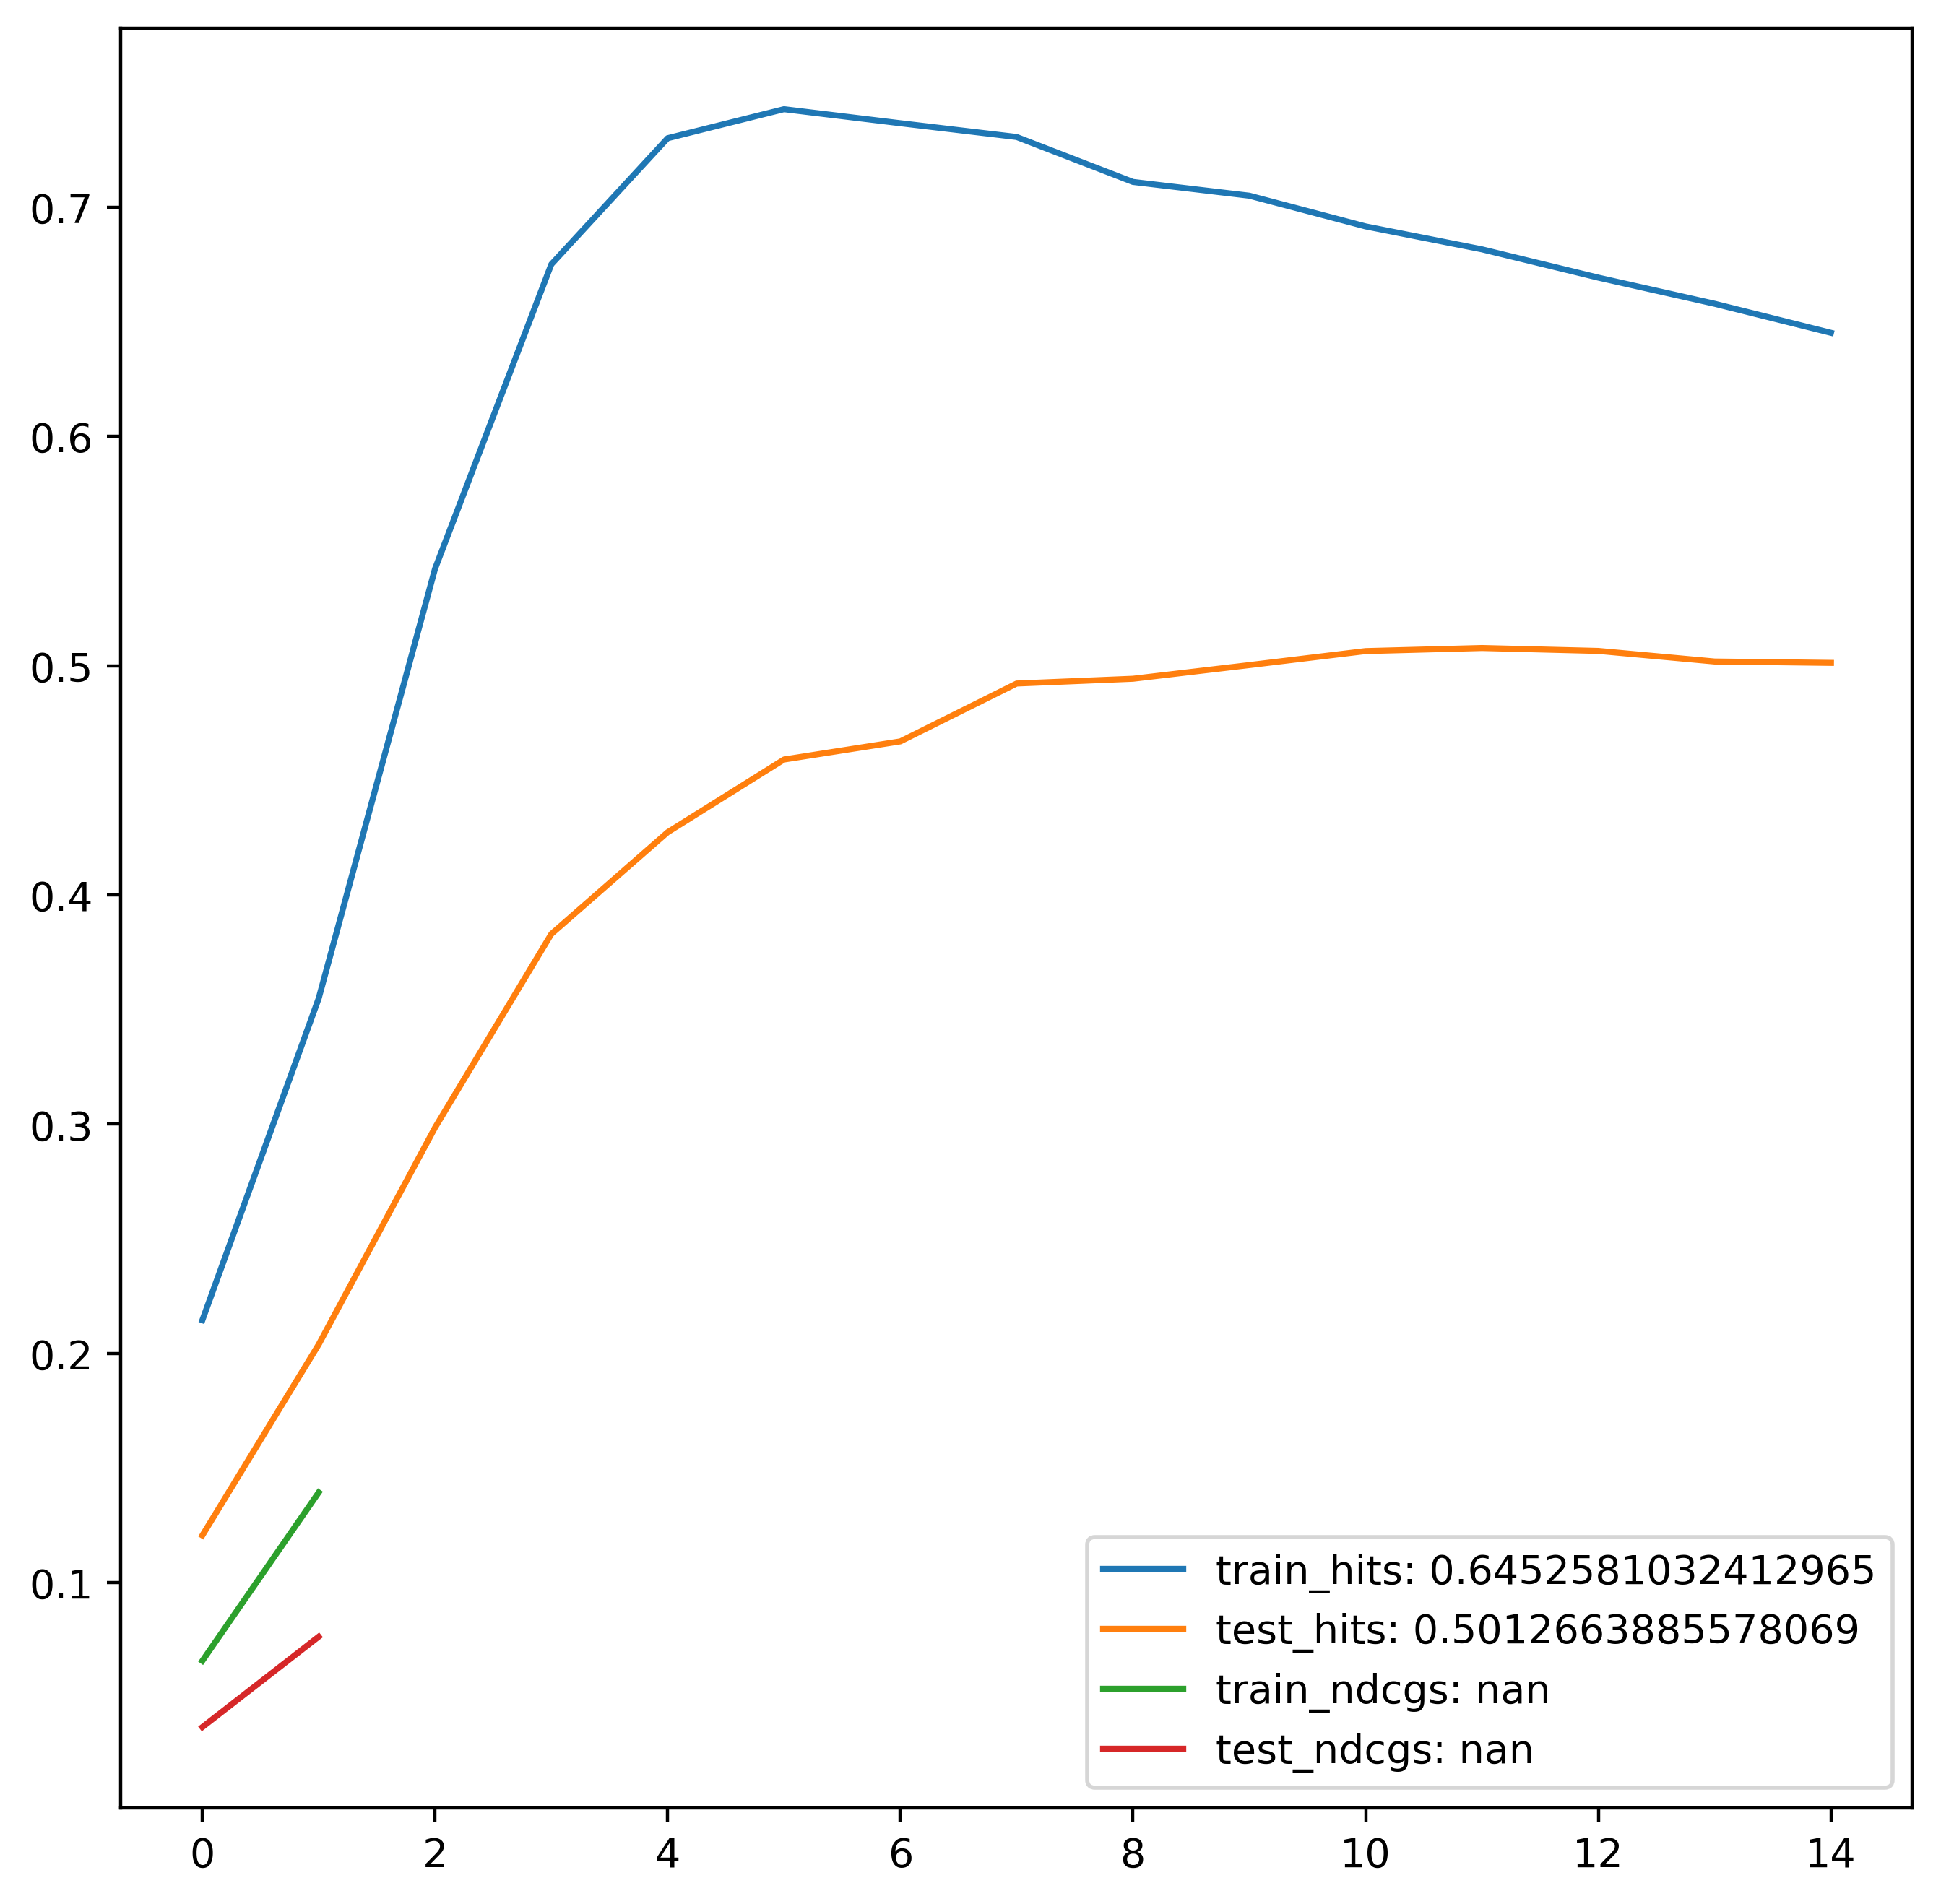

In [16]:
# Splits data into test and training data (used in test_acc function)
train, test = evaluation.train_test_split(data)

# Creates the model from implicit library
model_lmf = implicit.cpu.lmf.LogisticMatrixFactorization(factors = 30, iterations = 15, regularization=0.5)

# Stores the accuracy datas for both training and testing datasets
train_hits_lmf, test_hits_lmf, train_ndcgs_lmf, test_ndcgs_lmf = model_lmf.fit(train, callback = test_acc)

# Prints the final hits and NDCG of the model
print('Train Hits:', train_hits_lmf[-1], '\nTest Hits:', test_hits_lmf[-1],
      '\nTrain NDCG:', train_ndcgs_lmf[-1], '\nTest NDCG:', test_ndcgs_lmf[-1])

# Plots a graph 
plot_graph(train_hits_lmf, test_hits_lmf, train_ndcgs_lmf, test_ndcgs_lmf)

### Bayesian Personalized Ranking (BPR)

  0%|          | 0/150 [00:00<?, ?it/s]

Train Hits: 0.9380418834200347 
Test Hits: 0.7615127919911012 
Train NDCG: 0.4397822994497689 
Test NDCG: 0.35130183481454236


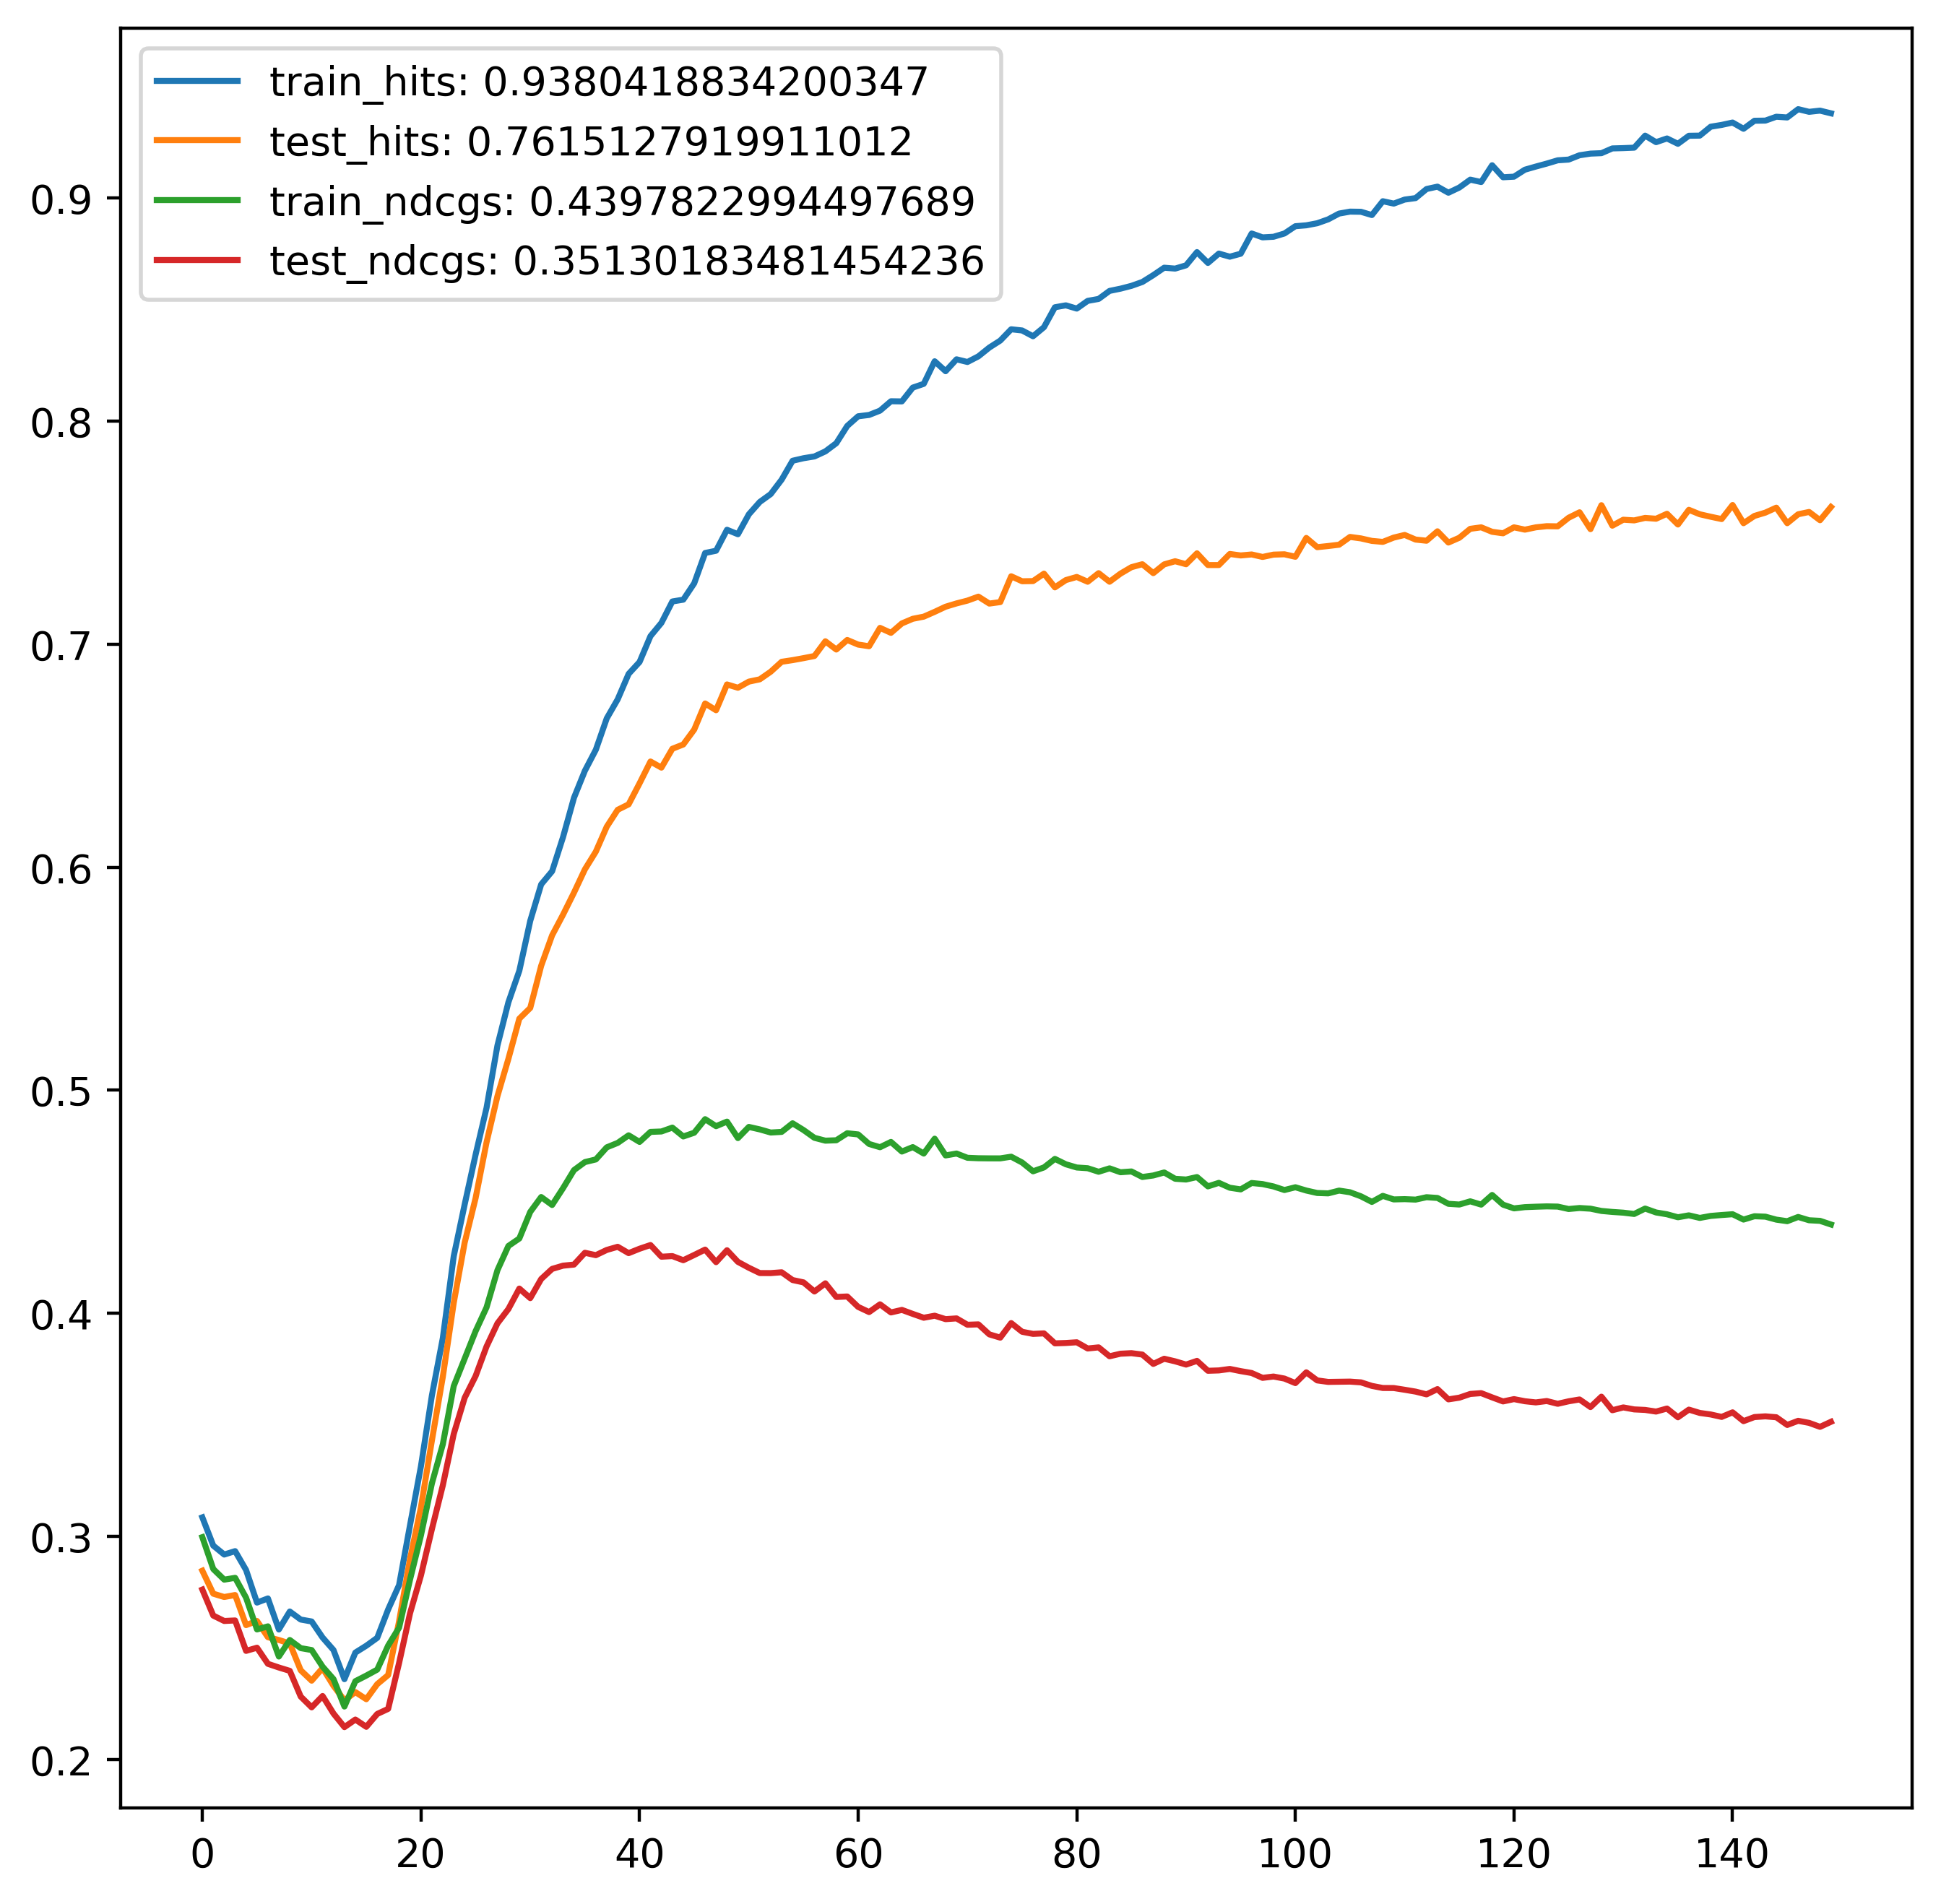

In [17]:
# Splits data into test and training data (used in test_acc function)
train, test = evaluation.train_test_split(data)

# Creates the model from implicit library
model_bpr = implicit.cpu.bpr.BayesianPersonalizedRanking(factors=100, learning_rate = 0.01, iterations=150)

# Stores the accuracy datas for both training and testing datasets
train_hits_bpr, test_hits_bpr, train_ndcgs_bpr, test_ndcgs_bpr = model_bpr.fit(train, callback = test_acc)

# Prints the final hits and NDCG of the model
print('Train Hits:', train_hits_bpr[-1], '\nTest Hits:', test_hits_bpr[-1],
      '\nTrain NDCG:', train_ndcgs_bpr[-1], '\nTest NDCG:', test_ndcgs_bpr[-1])

# Plots a graph 
plot_graph(train_hits_bpr, test_hits_bpr, train_ndcgs_bpr, test_ndcgs_bpr)

### Alternating Least Squares (ALS)

  0%|          | 0/15 [00:00<?, ?it/s]

Train Hits: 0.8979455709711847 
Test Hits: 0.7260905105149736 
Train NDCG: 0.8508369137648466 
Test NDCG: 0.6904297003675375


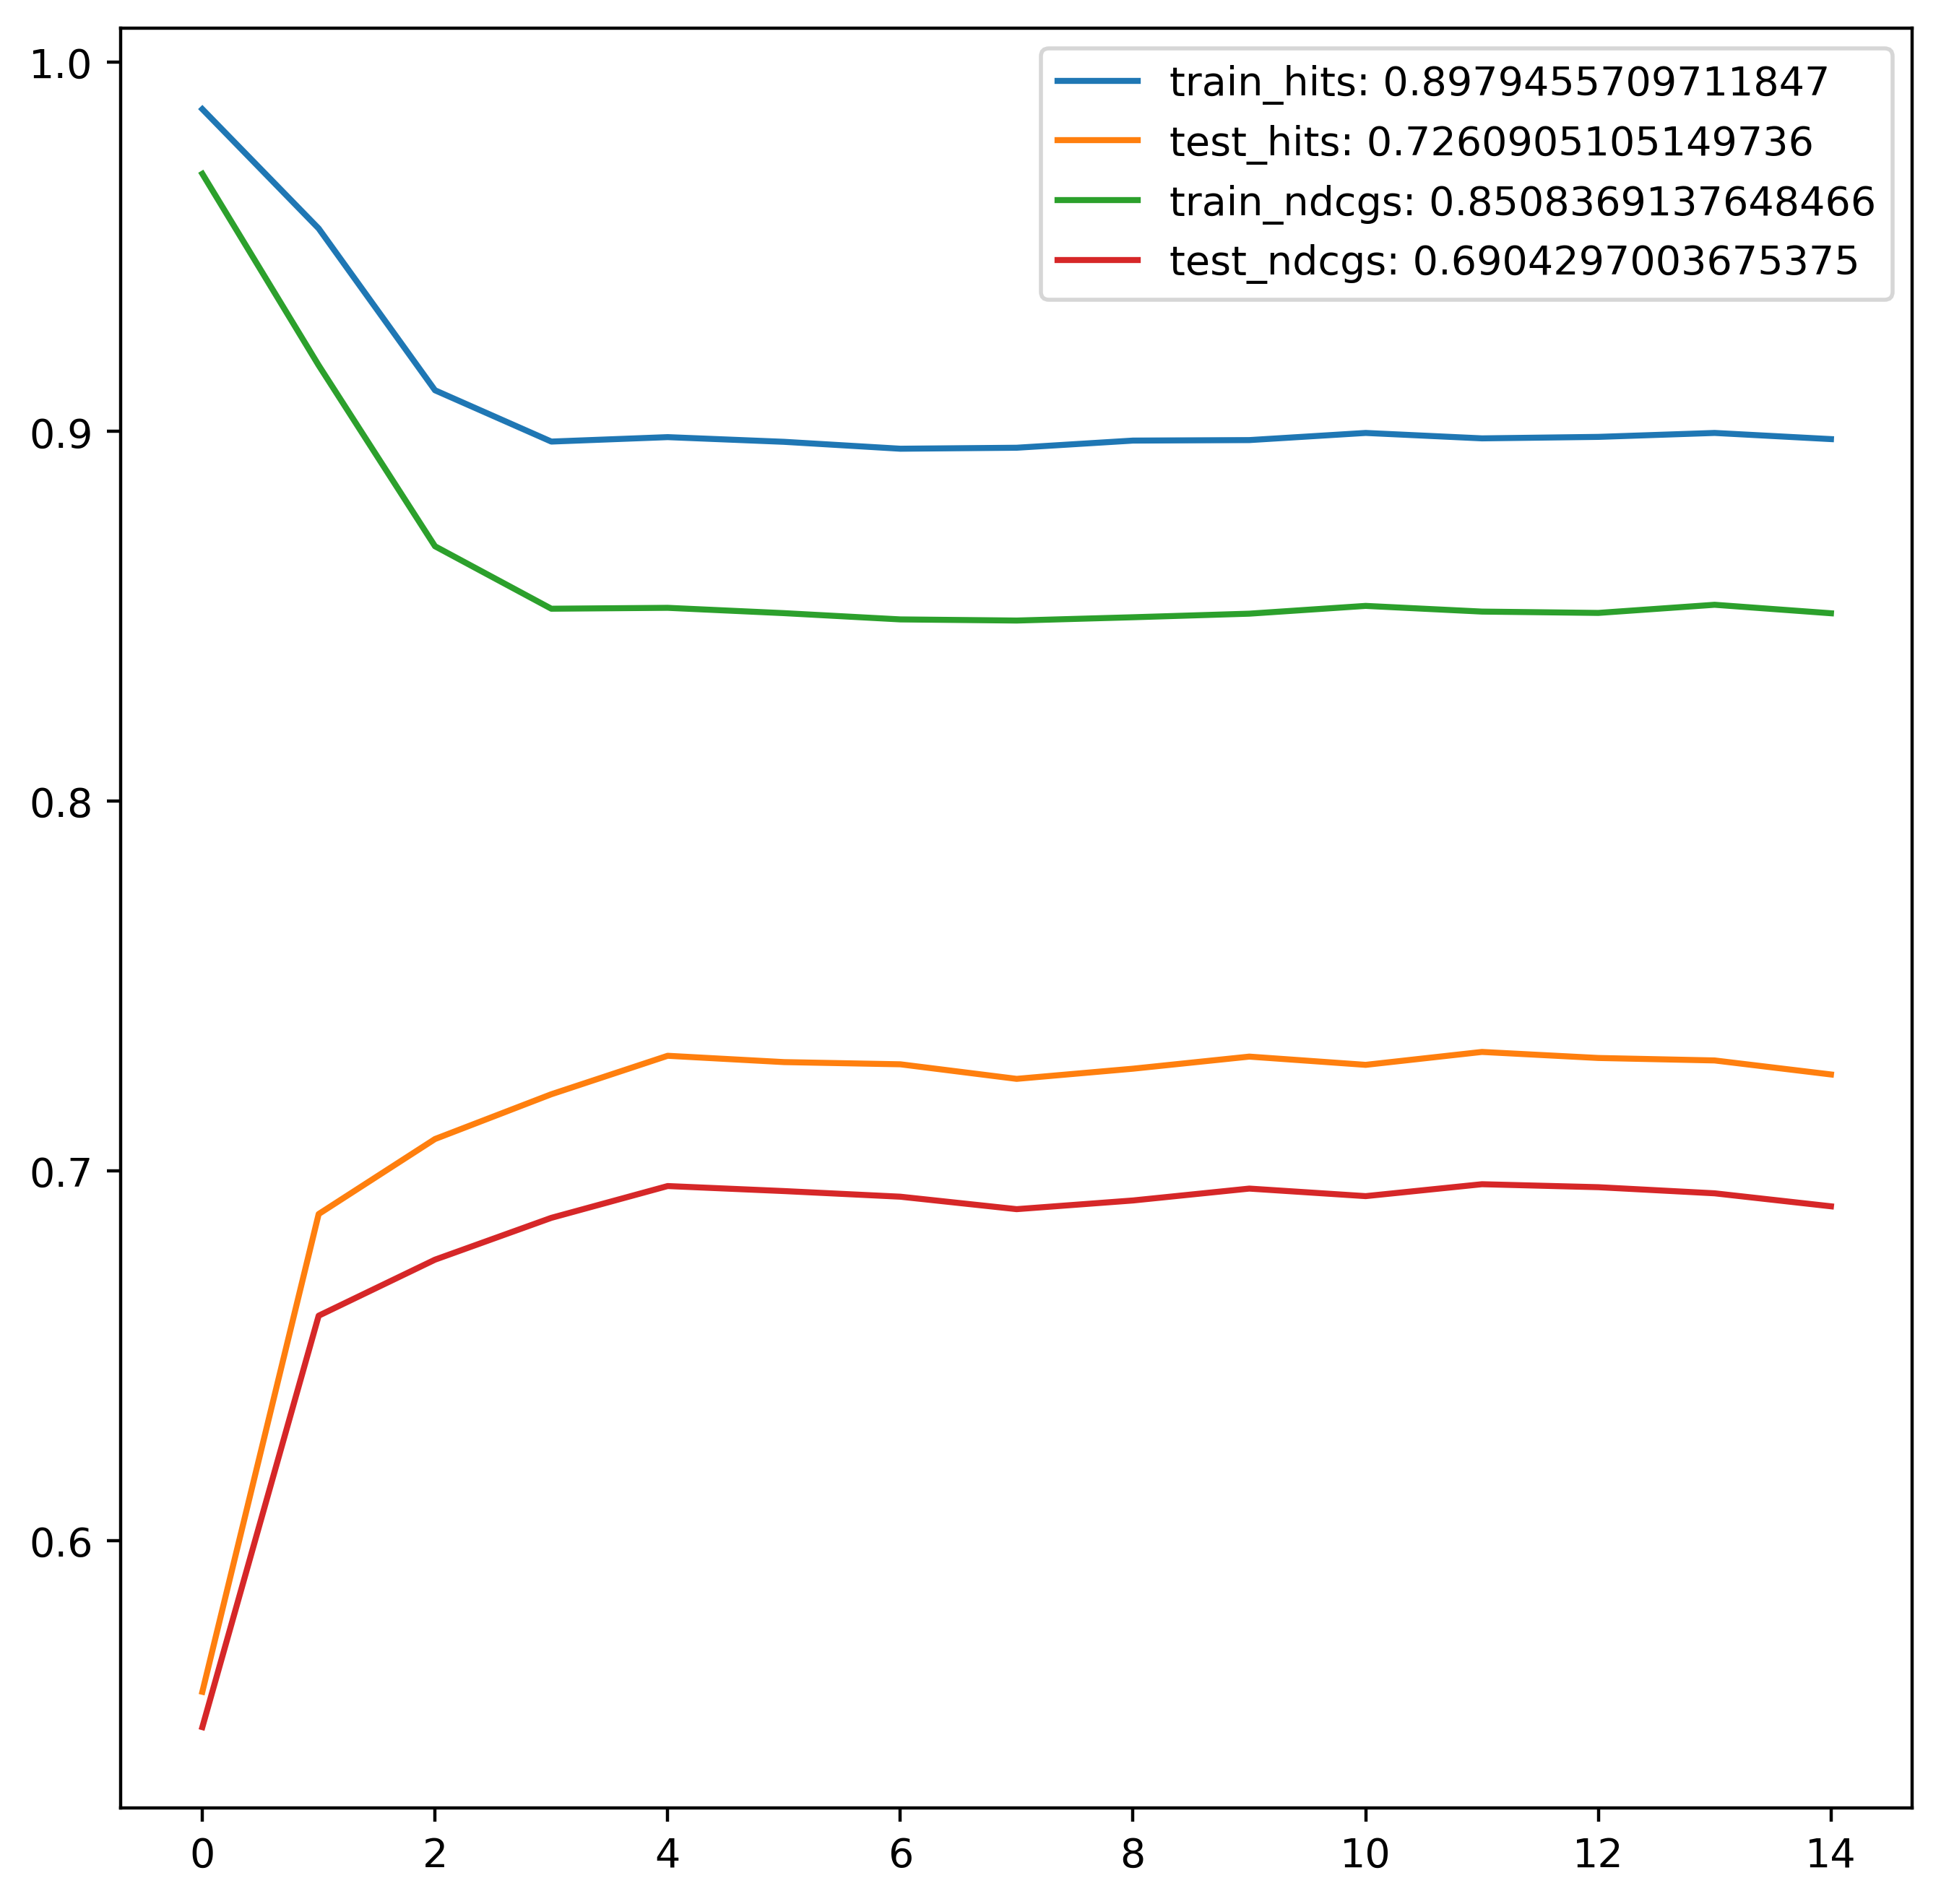

In [124]:
# Splits data into test and training data (used in test_acc function)
train, test = evaluation.train_test_split(data)

# Creates the model from implicit library
model_als = implicit.cpu.als.AlternatingLeastSquares(factors = 100, iterations = 15)

# Stores the accuracy datas for both training and testing datasets
train_hits_als, test_hits_als, train_ndcgs_als, test_ndcgs_als = model_als.fit(train, callback = test_acc)

# Prints the final hits and NDCG of the model
print('Train Hits:', train_hits_als[-1], '\nTest Hits:', test_hits_als[-1],
      '\nTrain NDCG:', train_ndcgs_als[-1], '\nTest NDCG:', test_ndcgs_als[-1])

# Plots a graph 
plot_graph(train_hits_als, test_hits_als, train_ndcgs_als, test_ndcgs_als)

### Saves The Models

In [22]:
model_lmf.save('model_lmf.npz')
model_bpr.save('model_bpr.npz')
model_als.save('model_als.npz')

# Plots Models Together

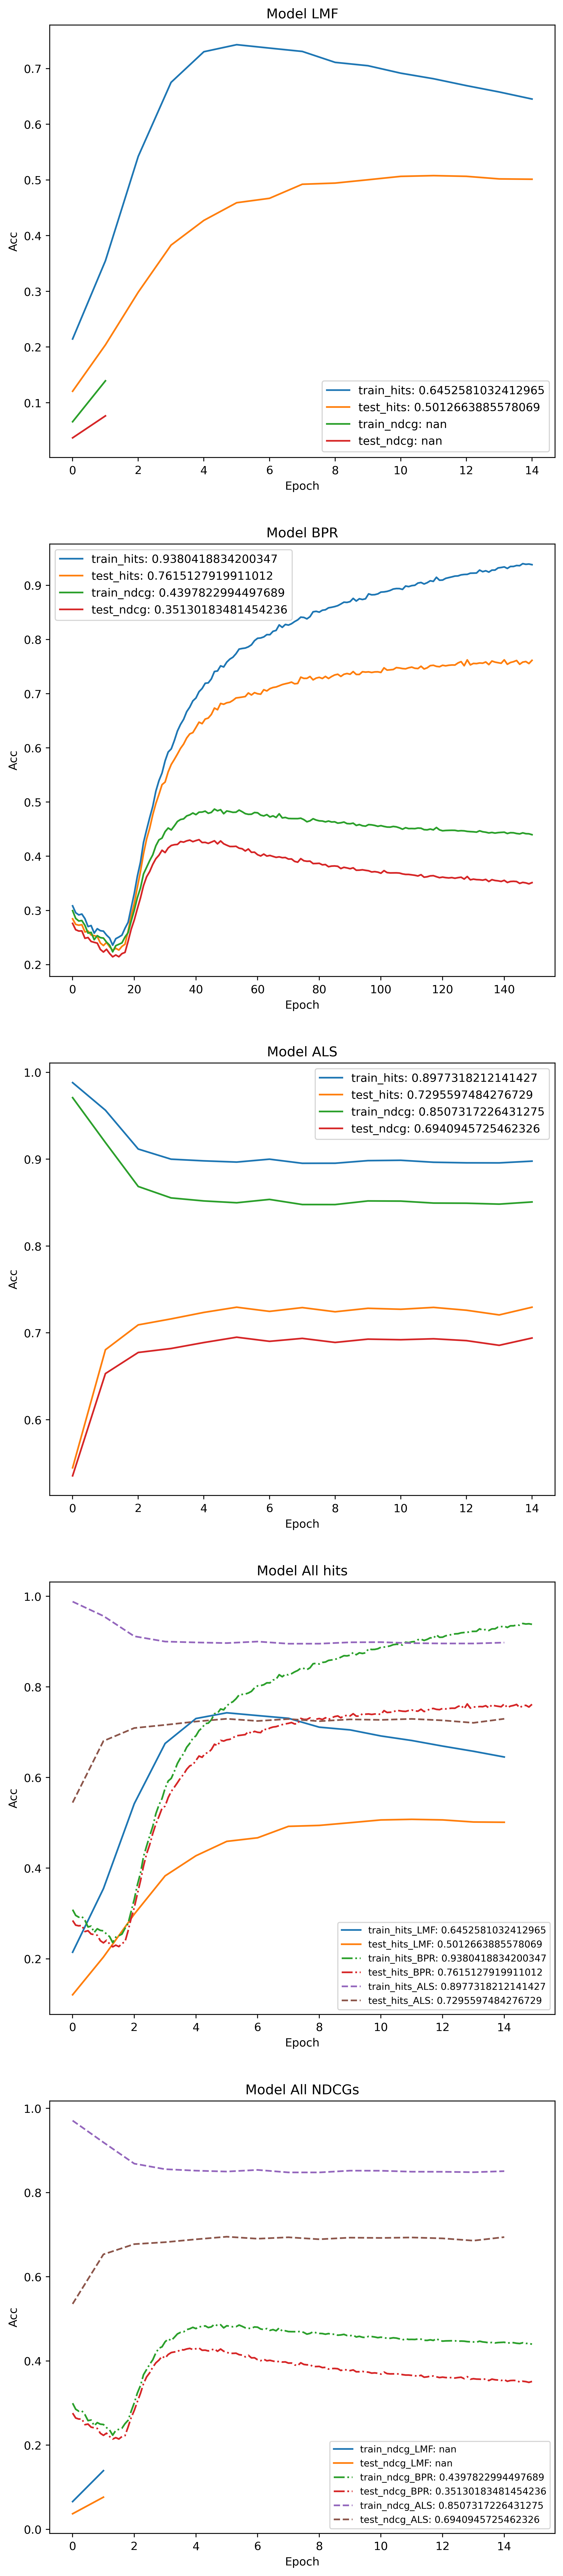

In [19]:
# Creates 5 different subplots
fig, axs = plt.subplots(5,1, figsize = (8, 40), dpi = 400)

# Creates a list of x's going to be used for plotting purposes
x = [np.arange(0,len(train_hits_lmf)), np.arange(0,len(train_hits_bpr)), np.arange(0,len(train_hits_als))]

# Creates a list of the different y values needed (training and testing hits and ndscgs)
y_train_hits = [train_hits_lmf, train_hits_bpr, train_hits_als]
y_test_hits = [test_hits_lmf, test_hits_bpr, test_hits_als]
y_train_ndcgs = [train_ndcgs_lmf, train_ndcgs_bpr, train_ndcgs_als]
y_test_ndcgs = [test_ndcgs_lmf, test_ndcgs_bpr, test_ndcgs_als]

# Model names and plotting style lists for plotting
model_names = ['LMF', 'BPR', 'ALS', 'All hits', 'All NDCGs']
plt_style = ['-', '-.', '--']

# For loop that plots out the 5 subplots
for i in range(5):

    # Plots the first three plots (similar to plots above)
    if i < 3:
        axs[i].plot(x[i], y_train_hits[i], label = f'train_hits: {y_train_hits[i][-1]}')
        axs[i].plot(x[i], y_test_hits[i], label = f'test_hits: {y_test_hits[i][-1]}')
        axs[i].plot(x[i], y_train_ndcgs[i], label = f'train_ndcg: {y_train_ndcgs[i][-1]}')
        axs[i].plot(x[i], y_test_ndcgs[i], label = f'test_ndcg: {y_test_ndcgs[i][-1]}')
        axs[i].legend()

    # Plots the fourth plot (All Hits together)
    elif i == 3:
        for j in range(3):
            if j != 1:
                x_s = x[j]
            else: x_s = [i/10 for i in x[j]]
            axs[i].plot(x_s, y_train_hits[j], plt_style[j], label = f'train_hits_{model_names[j]}: {y_train_hits[j][-1]}')
            axs[i].plot(x_s, y_test_hits[j], plt_style[j], label = f'test_hits_{model_names[j]}: {y_test_hits[j][-1]}')
        axs[i].legend(fontsize = 'small')
        
    # Plots the final plot(All NDCGS together)
    else:
        for j in range(3):
            if j != 1:
                x_s = x[j]
            else: x_s = [i/10 for i in x[j]]
            axs[i].plot(x_s, y_train_ndcgs[j], plt_style[j], label = f'train_ndcg_{model_names[j]}: {y_train_ndcgs[j][-1]}')
            axs[i].plot(x_s, y_test_ndcgs[j], plt_style[j], label = f'test_ndcg_{model_names[j]}: {y_test_ndcgs[j][-1]}')
        axs[i].legend(fontsize = 'small')
        
    # Sets labels and titles
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Acc')
    axs[i].title.set_text(f'Model {model_names[i]}')
    
plt.show()

# Creates Tables

In [20]:
# Creates dictionary with the final values of hits and ndcgs after training
table_dict = {'Train Hits' : [i[-1] for i in y_train_hits],
              'Test Hits' : [i[-1] for i in y_test_hits],
              'Train NDCGS' : [i[-1] for i in y_train_ndcgs],
              'Test NDCGS' : [i[-1] for i in y_test_ndcgs]}

# Creates a data frame using the dictionary
table = pd.DataFrame.from_dict(table_dict)

# Changes the table indices
table.index = ['LMF', 'BPR', 'ALS']

# Prints out the table
table

,Train Hits,Test Hits,Train NDCGS,Test NDCGS
LMF,0.645258,0.501266,NaN,NaN
BPR,0.938042,0.761513,0.439782,0.351302
ALS,0.897732,0.729560,0.850732,0.694095


# Model Subjective Testing

### Comparison to Spotify Recommendation System

Spotify API is limited to 5 songs in a playlist to recommend to, this code will read in the first 5 entries of a given playlist for the spotify recommendation, but will use the entire playlist in the different models

Good Playlists to Test On with 5 or less songs: 5967, 4041, 13736, 10537, 9878

In [152]:
# Initializes spotipy (client_id and client_secret needs to be filled in with your own client_id, client_secret
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id='INSERT CLIENT ID',
                                               client_secret='INSERT CLIENT SECRET', 
                                               scope="user-library-read", 
                                               redirect_uri='http://localhost/'))

In [222]:
# The playlist you wish to test on
test_plst_index = 4041

# Reads in track uris and track names for testing
test_playlist_track_uri = pl_lst_flat[test_plst_index][1]['track_uri']
test_playlist_track_names = pl_lst_flat[test_plst_index][1]['track_name'] + ', ' + pl_lst_flat[test_plst_index][1]['artist_name']

# Prints the testing playlist
print(f'Test Playlist:\n{test_playlist_track_names}')

# Calls the models to recommend 10 songs and returns the song ids and ranks
ids_lmf, ranks_lmf = model_lmf.recommend(test_plst_index, data[test_plst_index])

# Prints the recommended songs
print('\n\nLMF Recommendations:\n')
print([songs_list[i] for i in ids_lmf])

# Calls the models to recommend 10 songs and returns the song ids and ranks
ids_bpr, ranks_bpr = model_bpr.recommend(test_plst_index, data[test_plst_index])

# Prints the recommended songs
print('\n\nBPR Recommendations:\n')
print([songs_list[i] for i in ids_bpr])

# Calls the models to recommend 10 songs and returns the song ids and ranks
ids_als, ranks_als = model_als.recommend(test_plst_index, data[test_plst_index])

# Prints the recommended songs
print('\n\nALS Recommendations:\n')
print([songs_list[i] for i in ids_als])

# Calls Spotify API to recommend 10 songs using test playlist
recommends = sp.recommendations(seed_tracks = test_playlist_track_uri.tolist()[:5], limit = 10)

# Prints the recommended songs
print('\n\nSpotify Recommendations:\n')
print([recommends['tracks'][i]['name'] + ', ' + recommends['tracks'][i]['album']['artists'][0]['name']
       for i in range(len(recommends['tracks']))])

Test Playlist:
0           Ex-Factor, Ms. Lauryn Hill
1                         Mad, Solange
2           Cranes in the Sky, Solange
3    Broccoli (feat. Lil Yachty), DRAM
4             Futura Free, Frank Ocean
dtype: object


LMF Recommendations:

['Keep Ya Head Up, 2Pac', 'rockstar, Post Malone', 'Dear Mama, 2Pac', 'Gold, Kiiara', 'Sucker For Pain (with Wiz Khalifa, Imagine Dragons, Logic & Ty Dolla $ign feat. X Ambassadors), Lil Wayne', 'Ultralight Beam, Kanye West', 'Fade, Kanye West', 'One Dance, Drake', 'Feels Like We Only Go Backwards, Tame Impala', 'Redbone, Childish Gambino']


BPR Recommendations:

["Turnin' Me Up, BJ The Chicago Kid", 'Hello, Erykah Badu', 'Initiation, The Weeknd', "Really Love, D'Angelo", 'Tyrant (feat. Jorja Smith), Kali Uchis', 'Pink + White, Frank Ocean', 'Plastic 100°C, Sampha', 'Sweet Life, Frank Ocean', "Don't Touch My Hair, Solange", 'Be Your Girl, Teedra Moses']


ALS Recommendations:

['Thinkin Bout You, Frank Ocean', 'Pink + White, Frank Ocean', 'N

### Artist Searching

In [217]:
# Artist to search for
artist_search = "Foo Fighters"

# Prints playlists containing given artist
print(f'Playlists containing {artist_search}:\n')
print([i for i in range(15000) if artist_search in pl_lst_flat[i][1]['artist_name'].tolist()])

Playlists containing Foo Fighters:

[14, 32, 135, 307, 309, 323, 326, 331, 334, 367, 406, 498, 521, 580, 607, 625, 752, 772, 884, 891, 900, 921, 935, 1037, 1063, 1180, 1216, 1227, 1266, 1288, 1369, 1564, 1565, 1632, 1668, 1786, 1837, 1995, 2041, 2079, 2083, 2105, 2145, 2162, 2187, 2189, 2208, 2212, 2225, 2291, 2292, 2297, 2304, 2422, 2464, 2478, 2522, 2531, 2600, 2638, 2643, 2649, 2734, 2784, 2886, 2980, 3073, 3125, 3194, 3267, 3320, 3359, 3378, 3397, 3462, 3481, 3506, 3507, 3646, 3816, 3910, 3921, 3965, 4088, 4093, 4101, 4158, 4238, 4273, 4290, 4354, 4356, 4372, 4425, 4458, 4472, 4496, 4506, 4508, 4511, 4551, 4572, 4648, 4680, 4726, 4745, 4836, 4935, 4950, 4998, 5042, 5087, 5119, 5124, 5126, 5132, 5133, 5140, 5173, 5286, 5287, 5328, 5393, 5459, 5511, 5524, 5556, 5579, 5619, 5628, 5645, 5648, 5655, 5657, 5689, 5709, 5740, 5785, 5942, 5945, 5970, 5984, 5988, 6117, 6121, 6158, 6182, 6241, 6251, 6287, 6309, 6326, 6347, 6358, 6362, 6535, 6604, 6606, 6611, 6640, 6691, 6699, 6711, 6743, 6785

### Print Playlist Tracks

In [218]:
# Prints passed in playlist songs
playlist_to_print = 0
print((pl_lst_flat[playlist_to_print][1]['track_name'] + ', ' + pl_lst_flat[playlist_to_print][1]['artist_name']).tolist())

['Lose Control (feat. Ciara & Fat Man Scoop), Missy Elliott', 'Toxic, Britney Spears', 'Crazy In Love, Beyoncé', 'Rock Your Body, Justin Timberlake', "It Wasn't Me, Shaggy", 'Yeah!, Usher', 'My Boo, Usher', 'Buttons, The Pussycat Dolls', "Say My Name, Destiny's Child", 'Hey Ya! - Radio Mix / Club Mix, OutKast', 'Promiscuous, Nelly Furtado', 'Right Where You Want Me - Radio Edit Version, Jesse McCartney', 'Beautiful Soul, Jesse McCartney', "Leavin', Jesse McCartney", 'Me & U, Cassie', 'Ice Box, Omarion', 'Sk8er Boi, Avril Lavigne', 'Run It!, Chris Brown', 'Check On It - feat. Bun B and Slim Thug, Beyoncé', "Jumpin', Jumpin', Destiny's Child", 'Soak Up The Sun, Sheryl Crow', 'Where Is The Love?, The Black Eyed Peas', "Stacy's Mom, Bowling For Soup", 'Just The Girl, The Click Five', 'Yo (Excuse Me Miss), Chris Brown', 'Year 3000, Jonas Brothers', 'Lip Gloss, Lil Mama', 'Everytime We Touch - Radio Edit, Cascada', 'Whatcha Say, Jason Derulo', 'Miss Independent, Ne-Yo', 'Party In The U.S.A.,

### Print Playlists under a certain song limit

In [194]:
# Song limit for playlists
song_limit = 6

# Prints playlists under this song limit
print(f'Playlists under {song_limit} songs:\n')
print([i for i in range(15000) if (len(pl_lst_flat[i][1]['track_name'] + ', ' + pl_lst_flat[i][1]['artist_name']) < song_limit)])

Playlists under 6 songs:

[54, 74, 206, 233, 278, 336, 387, 706, 1038, 1230, 1231, 1524, 1774, 1914, 2510, 2594, 2714, 2851, 3106, 3311, 3561, 3884, 4041, 4103, 4110, 4321, 4786, 4981, 5109, 5738, 5756, 5895, 5967, 6047, 6213, 6521, 6943, 7139, 7369, 7421, 8067, 8169, 8361, 8647, 8728, 8935, 9029, 9264, 9317, 9428, 9717, 9819, 9878, 10005, 10257, 10429, 10537, 10556, 10616, 11023, 11773, 11814, 12238, 12320, 12479, 12828, 13292, 13311, 13736, 14225, 14308, 14801, 14887]


### Get Playlist Id

In [220]:
pl_lst_flat[0][0]

name             Throwbacks
collaborative         false
pid                       0
modified_at      1493424000
num_tracks               52
num_albums               47
num_followers             1
num_edits                 6
duration_ms        11532414
num_artists              37
Name: 0, dtype: object